# Micro Model

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import os
import numpy as np
import pandas as pd
import imageio
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
base_path = "data/img_data"

In [3]:
class_list = [f for f in os.listdir(base_path) if not f.startswith(".")]
class_list

['car', 'helicopter', 'rocket']

In [4]:
class_no = len(class_list)
class_no

3

In [5]:
img_dfs = []
for c in class_list:
    img_list = [f"{base_path}/{c}/{f}"for f in os.listdir(f"{base_path}/{c}") if not f.startswith(".")]
    class_df = pd.DataFrame(img_list, columns=["image"])
    class_df["class"] = c
    img_dfs.append(class_df)

In [6]:
df = pd.concat(img_dfs)
df = df.reset_index(drop=True)

In [7]:
img_dims = (32,32)

In [8]:
len(df)

1475

In [9]:
# reading and rescaling images
X_list = []
for i, j in tqdm(df.iterrows(),total=len(df)):
    raw_img = imageio.imread(j[0])
    img = cv2.resize(raw_img, img_dims, interpolation=cv2.INTER_CUBIC)
    X_list.append(img)
X_array = np.array(X_list)

100%|██████████| 1475/1475 [00:45<00:00, 32.56it/s]


In [10]:
X_data = X_array/255

In [11]:
# one-hot encoding label data
y_list = []
for i, j in df.iterrows():
    ohe_init = np.zeros(class_no)
    label = j[1]
    ohe_init[class_list.index(label)] = 1
    ohe_label = ohe_init
    y_list.append(ohe_label)
y_data = np.array(y_list)

In [12]:
X_train, X_tv, y_train, y_tv = train_test_split(X_data,
                                                y_data,
                                                random_state=123,
                                                test_size=0.3,
                                                stratify=y_data)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_tv,
                                                y_tv,
                                                random_state=123,
                                                test_size=0.5,
                                                stratify=y_tv)

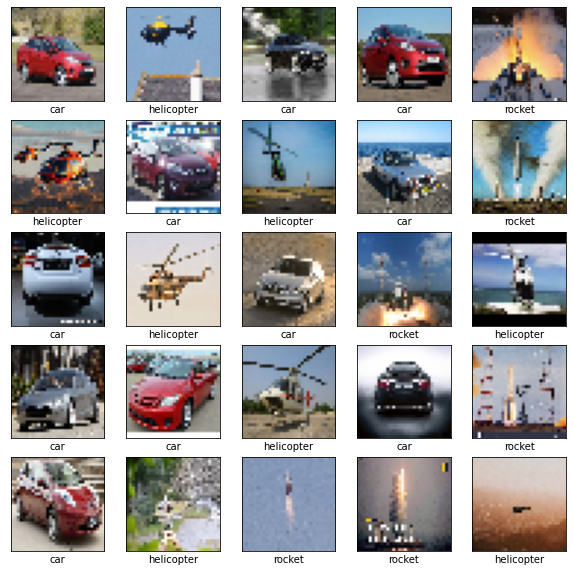

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_list[np.argmax([y_train[i]])])
plt.show()

In [15]:
def my_model():
    
    inputs = tf.keras.Input(shape=X_data.shape[1:])
    
    x = tf.keras.layers.Conv2D(4,(3,3),activation='relu',padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(class_no, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
n_epochs = 10
batch_size = 32

In [17]:
%%time
my_model = my_model()

history = my_model.fit(X_train,
                        y_train,
                        validation_data=(X_val,y_val),
                        epochs=n_epochs,
                        batch_size=batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 33,011
Trainable params: 33,011
Non-trainable params: 0
_________________________________________________________

In [18]:
(val_loss, val_acc) = my_model.evaluate(X_val,y_val,verbose=1)
(test_loss, test_acc) = my_model.evaluate(X_test,y_test,verbose=1)
print('---')
print(f'Val Loss: {val_loss}')
print(f'Val Accuracy: {val_acc}')
print('---')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

7/7 [==============================] - 0s 5ms/step - loss: 0.4450 - accuracy: 0.8243
---
Val Loss: 0.4064319431781769
Val Accuracy: 0.8190045356750488
---
Test Loss: 0.4450402557849884
Test Accuracy: 0.8243243098258972


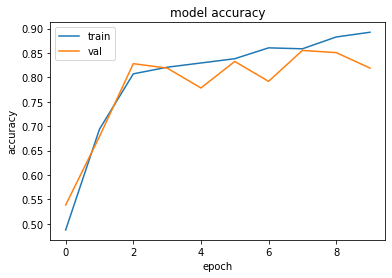

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

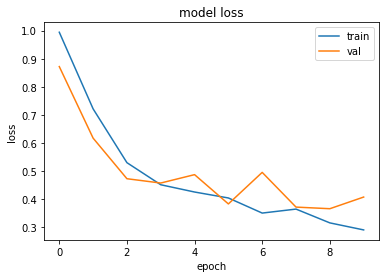

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [21]:
import sklearn.metrics

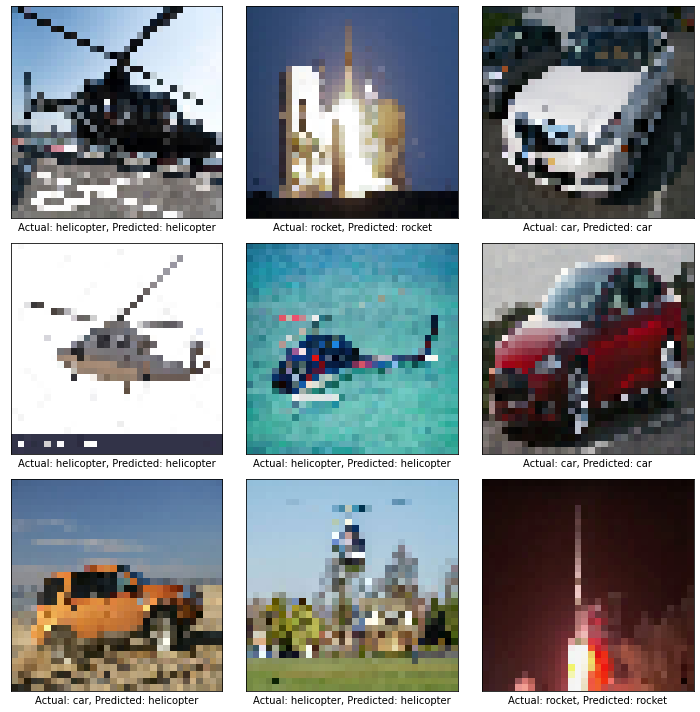

In [68]:
plt.figure(figsize=(10,10))
samples = 9
indices = np.random.choice(X_test.shape[0],samples,replace=False)
for i in range(samples):
    plt.subplot(int(samples**0.5),int(samples**0.5),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = X_test[indices[i]]
    actual = class_list[np.argmax(y_test[indices[i]])]
    sample = np.expand_dims(img,axis=0)
    prediction = class_list[np.argmax(my_model.predict(sample),axis=1)[0]]
    result = "FAIL"
    if actual == prediction:
        result = "PASS"
    plt.title(result)
    plt.imshow(img)
    plt.xlabel(f"A: {actual}; P: {prediction}")
plt.tight_layout()
plt.show()

In [62]:
y_hat = np.argmax(my_model.predict(X_test,verbose=1),axis=1)
y = np.argmax(y_test,axis=1)

In [63]:
confusion_matrix = sklearn.metrics.confusion_matrix(y,y_hat)
confusion_matrix = np.true_divide(confusion_matrix, confusion_matrix.sum(axis=1, keepdims=True))
cm_df = pd.DataFrame(confusion_matrix, class_list, class_list)

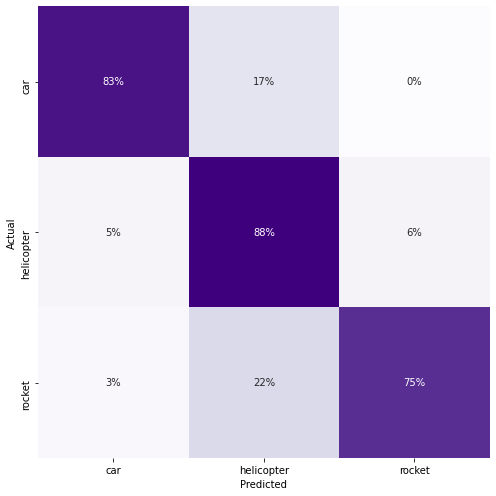

In [66]:
plt.figure(figsize=(7,7))
sns.heatmap(cm_df, cmap='Purples', cbar=False, annot=True,fmt='.0%')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
# plt.savefig("cm.png")
plt.show()

## X

In [88]:
sample_i = 72

In [89]:
dim = 32
kernel_no = 4
kernel_size = 3

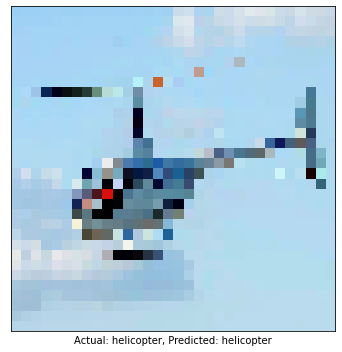

In [90]:
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
X_img = X_test[sample_i]
y_actual = class_list[np.argmax(y_test[sample_i])]
y_pred = class_list[np.argmax(my_model.predict(np.expand_dims(X_img,axis=0)),axis=1)[0]]
plt.imshow(X_img)
plt.xlabel(f"Actual: {y_actual}, Predicted: {y_pred}")
plt.tight_layout()
plt.show()

In [92]:
# SOFTMAX OUTPUT FOR SAMPLE
[i for i in my_model.predict(np.expand_dims(X_img,axis=0))[0]]

[0.00498324, 0.99333405, 0.0016826554]

In [ ]:
# WORKING VERSION OF SAMPLE EXTRACTOR
# sample_extract = pd.DataFrame(X_test[sample_i].swapaxes(0,1).transpose([1,2,0]).reshape(dim,(dim*3)))
# sample_extract.to_excel('data/param_extracts/sample_extract.xlsx')

In [ ]:
# WORKING VERSION OF ACTIVATIONS EXTRACTOR
# sample = np.expand_dims(X_test[sample_i],axis=0)
# layer_name = 'conv2d'
# intermediate_layer_model = tf.keras.Model(inputs=my_model.input,
#                                  outputs=my_model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(sample)

# result = pd.DataFrame(np.squeeze(intermediate_output,0).swapaxes(0,1).transpose([1,2,0]).reshape(dim,(dim*kernel_no)))
# result.to_excel('data/param_extracts/conv_1_activations.xlsx')

In [84]:
# WORKING VERSION OF CONV WEIGHTS EXTRACTOR
# Format:
#     K1 Ch1
#     K1 Ch2
#     K1 Ch3
#     K2 Ch1
#     ...
# c1_w = pd.DataFrame(my_model.get_weights()[0].transpose(3,2,0,1).reshape((3*kernel_no*kernel_size),kernel_size))
# c1_w.to_excel('data/param_extracts/c1_w.xlsx')

In [85]:
# c1_b = pd.DataFrame(my_model.get_weights()[1])
# c1_b.to_excel('data/param_extracts/c1_b.xlsx')
# d1_w = pd.DataFrame(my_model.get_weights()[2])
# d1_w.to_excel('data/param_extracts/d1_w.xlsx')
# d1_b = pd.DataFrame(my_model.get_weights()[3])
# d1_b.to_excel('data/param_extracts/d1_b.xlsx')
# d2_w = pd.DataFrame(my_model.get_weights()[4])
# d2_w.to_excel('data/param_extracts/d2_w.xlsx')
# d2_b = pd.DataFrame(my_model.get_weights()[5])
# d2_b.to_excel('data/param_extracts/d2_b.xlsx')